In [6]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as MAE
import scipy.signal as signal
import os

import warnings
warnings.filterwarnings("ignore") #one library really likes telling me a function is out of date


In [7]:
files = os.listdir(path="data")
data = {}
for file in files:
    rawdata = pandas.read_csv("data\\" + file)
    data[file] = []
    data[file].append(rawdata.iloc[1:, 0].reset_index(drop=True)) #remove header 'label'
    data[file].append(rawdata.iloc[1:, 1].reset_index(drop=True)) #remove header 'estimate'
    #changed to appropriate float format for matplotlib
    data[file][0] = data[file][0].astype(np.float64) 
    data[file][1] = data[file][1].astype(np.float64) 

lowestmae = 1
for file in data: #iterate the keys of data dict
    mae = MAE(data[file][0],data[file][1])
    if lowestmae > mae:
        lowestmae = mae
        lowFile = file
        print(lowFile, lowestmae)

#data intake structure
#dictionary list of files where key is file name and value is list
#list contains [0] *(ground truth) [1] *(prediction)

LABELS = data[lowFile][0]
BESTIMATES = data[lowFile][1]
print("here", lowFile, lowestmae)

#outputs:
#"data" containing all files 
#"estimates" which contains lowest file data, and "labels" which contains lowest files labels


TF02v2_dropout0.2_hsize50_ksize4_levels5_lossMSELoss_lr0.0001_optAdam_pred0.csv 0.1637338008201081
TF15v2_dropout0.1_hsize10_ksize5_levels4_lossMSELoss_lr0.0001_optAdam_pred0.csv 0.06154665576592832
TF15v2_dropout0.1_hsize10_ksize5_levels4_lossMSELoss_lr0.0005_optAdam_pred0.csv 0.057670708655971924
TF15v2_dropout0.2_hsize10_ksize10_levels3_lossMSELoss_lr0.0001_optAdam_pred0.csv 0.057139776071283885
TF15v2_dropout0.2_hsize10_ksize4_levels5_lossMSELoss_lr0.0001_optAdam_pred0.csv 0.05396813275523606
TF15v2_dropout0.2_hsize30_ksize7_levels4_lossMSELoss_lr0.0001_optAdam_pred0.csv 0.04876043135265504
TF15v2_dropout0.2_hsize50_ksize4_levels5_lossMSELoss_lr0.0001_optAdam_pred0.csv 0.04539013589577825
here TF15v2_dropout0.2_hsize50_ksize4_levels5_lossMSELoss_lr0.0001_optAdam_pred0.csv 0.04539013589577825


Kalmans 0.04133862020242521
Kalmans Double 0.043027346120960284
Kalmans FiltFilt 0.03841806386905003
Holt-Kalmans 0.039118560935930066
Savgol 0.038105530168357465


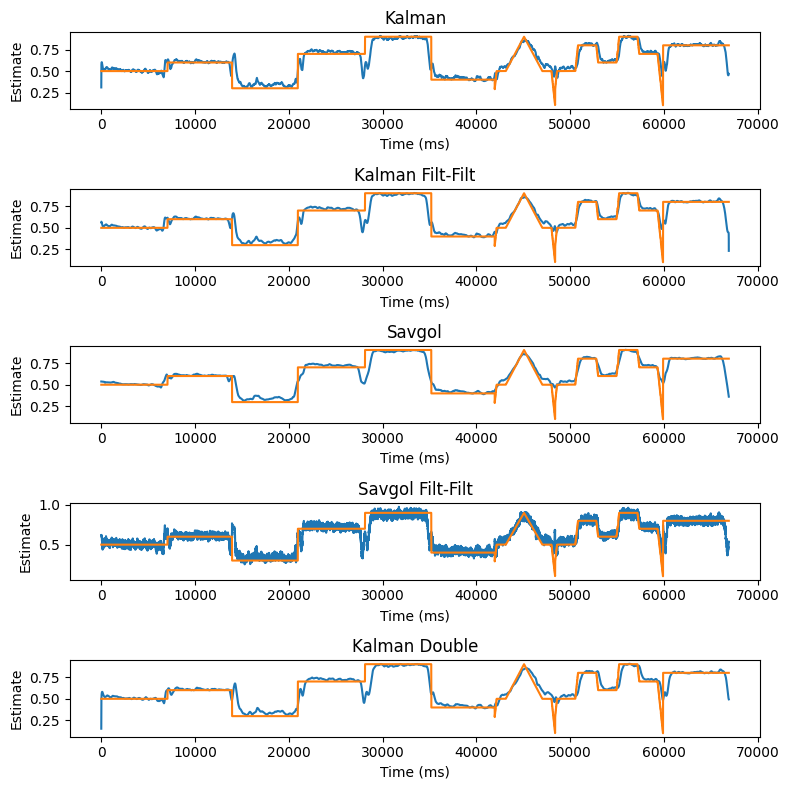

In [8]:
def kalman_filter(predictions, process_noise = 1e-5, measurement_var = 0.1, filtfilt = False):
    estimates = []
    # Initialize            
    prior_estimate = 0
    prior_var = 0.1
    for i in range(len(predictions)):
        slope_measurement = np.float64(predictions[i])
        # Update
        kalman_gain = prior_var / (prior_var + measurement_var) # Kn
        estimate = prior_estimate + kalman_gain*(slope_measurement-prior_estimate) # Xnn
        estimates.append(estimate)
        estimate_var = (1-kalman_gain)*prior_var # Pnn
        # Dynamics
        prior_estimate = estimate
        prior_var = estimate_var + process_noise
    if filtfilt:
        estimates = kalman_filter(estimates[::-1], filtfilt=False)[::-1]
    return estimates

def holt_winters_second_order_ewma(x, span, beta):
    N = x.size
    alpha = 2.0 / ( 1 + span )
    s = np.zeros(( N, ))
    b = np.zeros(( N, ))
    s[1] = x[1]
    for i in range( 1, N ):
        s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
        b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
    return s

#kalman filter single
kalmanEstimates = kalman_filter(BESTIMATES)
print("Kalmans", MAE(LABELS, kalmanEstimates))

#checking if running twice is good
kalmanEstimatesDouble = kalman_filter(list(BESTIMATES))
kalmanEstimatesDouble = kalman_filter(list(kalmanEstimatesDouble))
print("Kalmans Double", MAE(LABELS, kalmanEstimatesDouble))

#forward-backward kalman filter implementation
kalmanEstimatesFiltFilt = kalman_filter(BESTIMATES, filtfilt=True)
print("Kalmans FiltFilt", MAE(LABELS, kalman_filter(BESTIMATES, filtfilt=True)))

#prosepective filter implmentation
tempestimates = BESTIMATES
holtsEstimates = holt_winters_second_order_ewma(tempestimates, 122, 1e-2)
holtKalmanEstimate = kalman_filter(holtsEstimates, filtfilt=True)
print("Holt-Kalmans", MAE(LABELS, holtKalmanEstimate))

#savgol filter test
savgolEstimates = signal.savgol_filter(BESTIMATES, 610, 1)
print("Savgol", MAE(LABELS, savgolEstimates))

#savgol filt filt implementation
a = signal.savgol_coeffs(610, 1)
savgolEstimatesFiltFilt = signal.filtfilt(a, a, BESTIMATES, padtype="constant", padlen=1000)
# savgolEstimatesFiltFilt = signal.savgol_filter(BESTIMATES, 610, 1)
# savgolEstimatesFiltFilt = signal.savgol_filter(savgolEstimatesFiltFilt[::-1], 610, 1)[::-1]
# print("Savgol FiltFilt", MAE(LABELS, savgolEstimatesFiltFilt))

fig2, (ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=5, ncols=1)
fig2.set_size_inches(8, 8)

ax2.set_title("Kalman")
ax2.plot(kalmanEstimates)
ax2.plot(LABELS)

ax3.set_title("Kalman Filt-Filt")
ax3.plot(kalmanEstimatesFiltFilt)
ax3.plot(LABELS)

ax4.set_title("Savgol")
ax4.plot(savgolEstimates)
ax4.plot(LABELS)

ax5.set_title("Savgol Filt-Filt")
ax5.plot(savgolEstimatesFiltFilt)
ax5.plot(LABELS)

ax6.set_title("Kalman Double")
ax6.plot(kalmanEstimatesDouble)
ax6.plot(LABELS) 

for i in [ax2, ax3, ax4, ax5, ax6]:
    i.set_xlabel("Time (ms)")
    i.set_ylabel("Estimate")

fig2.tight_layout()
plt.show()

In [9]:
# savgolCOEs = {}
# for coeOne in range (1, 720):
#     for coeTwo in range(1, 10):
#         try:
#             savgol = signal.savgol_filter(BESTIMATES, coeOne, coeTwo)
#             savgolCOEs[MAE(LABELS, savgol)] = [coeOne, coeTwo]
#         except:
#             continue
#     print(str(coeOne) + " completed!")

# print("best coes were", *savgolCOEs[min(savgolCOEs)])
# savgolEstimates = signal.savgol_filter(BESTIMATES, *savgolCOEs[min(savgolCOEs)])

# fig2, (ax2) = plt.subplots(nrows=1, ncols=1)
# ax2.set_title("Savgol")
# ax2.plot(savgolEstimates)
# ax2.plot(LABELS)



In [10]:
# #spike filtering implementation
# def holt_winters_second_order_ewma(x, span, beta):
#     N = x.size
#     alpha = 2.0 / ( 1 + span )
#     s = np.zeros(( N, ))
#     b = np.zeros(( N, ))
#     s[1] = x[1]
#     for i in range( 1, N ):
#         s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
#         b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
#     return s

# lowest = {}
# for coeOne in range (1, 200): #previous best 122 1e-08
#     for coeTwo in [1e-15,1e-16,1e-17,1e-18,1e-19,1e-20]:
#         holts = holt_winters_second_order_ewma(BESTIMATES, coeOne, coeTwo)
#         lowest[MAE(LABELS, holts)] = [coeOne, coeTwo]
#     print(str(coeOne) + " completed!")


# holts = holt_winters_second_order_ewma(BESTIMATES, *lowest[min(lowest)])
# print(*lowest[min(lowest)])
# holts2 = holt_winters_second_order_ewma(BESTIMATES, 10, 0.0001)

# fig2, (ax2, ax3 ) = plt.subplots(nrows=2, ncols=1) # two axes on figure
# ax2.set_title("Holts")
# ax2.plot(holts)
# ax2.plot(LABELS, label="ground")
# ax3.set_title("Holts2")
# ax3.plot(holts2)
# ax3.plot(LABELS)

# fig2.tight_layout()
# plt.legend(loc="upper left")
# plt.show()


In [11]:
#finds lowest mae with filt filt settings
# butterCOEs = {}
# for coeOne in range (1, 20):
#     for coeTwo in np.arange(0, 1, 0.0001):
#         try:
#             b, a = signal.butter(coeOne, coeTwo) #butterworth
#             filtfiltEstimates = signal.filtfilt(b, a, BESTIMATES, padlen=150)
#             butterCOEs[MAE(LABELS, filtfiltEstimates)] = [coeOne, coeTwo]
#         except:
#             continue
#     print(str(coeOne) + " completed!")
# b, a = signal.butter(*butterCOEs[min(butterCOEs)])
# filtfiltEstimates = signal.filtfilt(b, a, BESTIMATES, padlen=150)
# print(MAE(LABELS, filtfiltEstimates))
# print(*butterCOEs[min(butterCOEs)])



In [12]:
def filter_peaks(left_speed):
    left_speed = pandas.DataFrame(left_speed) #convert to dataframe
    threshold = [np.mean(left_speed) - np.std(left_speed), np.mean(left_speed) + np.std(left_speed)]
    peaks = np.logical_or(left_speed > threshold[1], left_speed < threshold[0])
    peaks.iloc[[0,-1]] = False
    left_speed[peaks] = np.nan
    left_speed = left_speed.interpolate()
    left_speed = left_speed.iloc[:, 0]
    return left_speed

In [13]:
MAEs = {}
for file in data:
    #"constants" for this iteration
    MAEs[file] = {}
    estimates = data[file][1]
    labels = data[file][0]
    MAEs[file]["original"] = MAE(labels, estimates)
    
    #filtering implementation from jairo
    # tempestimates = estimates
    # sosEstimates = filter_peaks(tempestimates)
    # sos = signal.butter(4, 0.025, output='sos')
    # sosEstimates = kalman_filter(list(sosEstimates), process_noise=1e-5)
    # sosEstimates= signal.sosfiltfilt(sos, sosEstimates)
    # MAEs[file]["sos"] = MAE(labels, sosEstimates)

    #generate base case kalman estimates
    kalmanEstimates = kalman_filter(estimates)
    MAEs[file]["kalman"] = MAE(labels, kalmanEstimates)

    #zero-phase kalmans estimates
    zeroPhaseKalmanEstimates = kalman_filter(estimates, filtfilt=True)
    MAEs[file]["zerokalman"] = MAE(labels, zeroPhaseKalmanEstimates)
    
    #savgol estimates
    savgolEstimates = signal.savgol_filter(estimates, 610, 1)
    MAEs[file]["savgol"] = MAE(labels, savgolEstimates)
    
    # #replace estimate dataset with holts spike filtered set
    # holts = holt_winters_second_order_ewma(estimates, 122, 1e-15)
    # estimates = holts
    
    # #convolve with lowest mae calculation
    # lowestmae = 1
    # for a in range(2, 1000): #test values within reasonable range
    #     convolveEstimates = np.convolve(estimates, [1/a]*a)
    #     mae = MAE(labels, convolveEstimates[:-(a-1)])
    #     if mae < lowestmae:
    #         lowestmae = mae
    #         bestA = a
    # convolveEstimates = np.convolve(estimates, [1/bestA]*bestA)[:-(bestA-1)]
    # MAEs[file]["convolve"] = MAE(labels, convolveEstimates)

    b, a = signal.butter(6, 0.002)
    filtfiltEstimates = signal.filtfilt(b, a, estimates, padlen=150)
    MAEs[file]["filtfilt"] = MAE(labels, filtfiltEstimates)
    
    print("Original", MAE(labels, estimates))
    print("FiltFilt", MAE(labels, filtfiltEstimates))
    # print('Convolve', MAE(labels, convolveEstimates))
    print("Kalman  ", MAE(labels, kalmanEstimates))
    print("Kalman Zero", MAE(labels, zeroPhaseKalmanEstimates))
    # print("Sos     ", MAE(labels, sosEstimates))
    print(file, " completed!")
    print(files.index(file)+1, "of", len(files))


Original 0.1637338008201081
FiltFilt 0.16621545837671198
Kalman   0.16152009160970746
Kalman Zero 0.16062973502943265
TF02v2_dropout0.2_hsize50_ksize4_levels5_lossMSELoss_lr0.0001_optAdam_pred0.csv  completed!
1 of 95
Original 0.06154665576592832
FiltFilt 0.04391701418201389
Kalman   0.050452829593666884
Kalman Zero 0.048280120741666176
TF15v2_dropout0.1_hsize10_ksize5_levels4_lossMSELoss_lr0.0001_optAdam_pred0.csv  completed!
2 of 95
Original 0.057670708655971924
FiltFilt 0.04559415123420924
Kalman   0.05005036447159854
Kalman Zero 0.04674993425615081
TF15v2_dropout0.1_hsize10_ksize5_levels4_lossMSELoss_lr0.0005_optAdam_pred0.csv  completed!
3 of 95
Original 0.06615059226632107
FiltFilt 0.04491927227959504
Kalman   0.04863682959403984
Kalman Zero 0.04472606021233672
TF15v2_dropout0.1_hsize10_ksize5_levels4_lossMSELoss_lr0.001_optAdam_pred0.csv  completed!
4 of 95
Original 0.10872658130406831
FiltFilt 0.08249736724764863
Kalman   0.08550480667603243
Kalman Zero 0.08425871320239492
TF15

Original MAE 0.06254199295498641
FiltFilt 0.04809975011345702
Kalman   0.05360706591307606


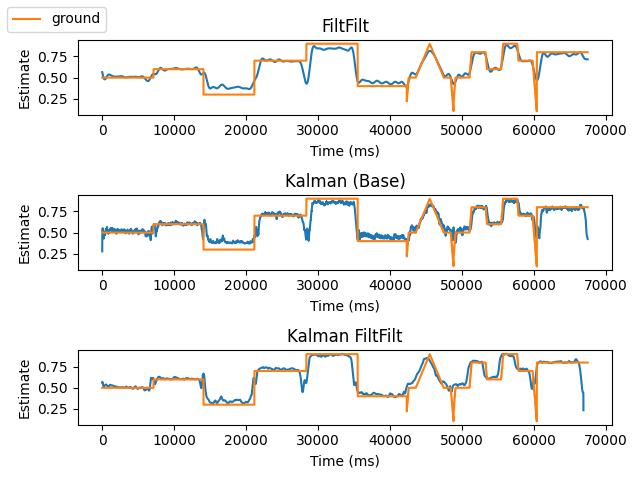

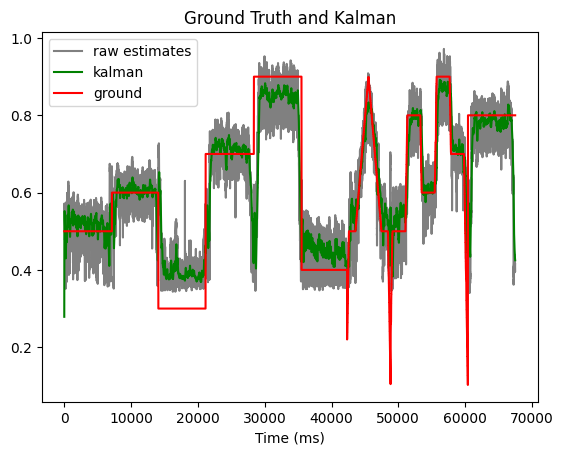

In [14]:
#Graphing cell for single data sample
from cProfile import label

fig2, (ax2, ax3, ax4) = plt.subplots(nrows=3, ncols=1) # two axes on figure
ax2.set_title("FiltFilt")
ax2.plot(filtfiltEstimates)
ax2.plot(labels, label="ground")
ax3.set_title("Kalman (Base)")
ax3.plot(kalmanEstimates)
ax3.plot(labels)
# ax4.set_title("Convolve")
# ax4.plot(convolveEstimates)
ax4.set_title("Kalman FiltFilt")
ax4.plot(kalmanEstimatesFiltFilt)
ax4.plot(labels)

for i in [ax2, ax3, ax4]:
    i.set_xlabel("Time (ms)")
    i.set_ylabel("Estimate")

fig2.legend(loc="upper left")
fig2.tight_layout()

fig1, ax1 = plt.subplots()
ax1.plot(estimates, label="raw estimates", color="gray")
ax1.plot(kalmanEstimates, label="kalman", color="green")
ax1.plot(labels, label="ground", color="red")
ax1.set_title("Ground Truth and Kalman")
ax1.set_xlabel("Time (ms)")

print("Original MAE", MAE(labels, estimates))
print("FiltFilt", MAE(labels, filtfiltEstimates))
# print('Convolve', MAE(labels, convolveEstimates))
print("Kalman  ", MAE(labels, kalmanEstimates))


plt.legend(loc="upper left")
plt.show()


9 86


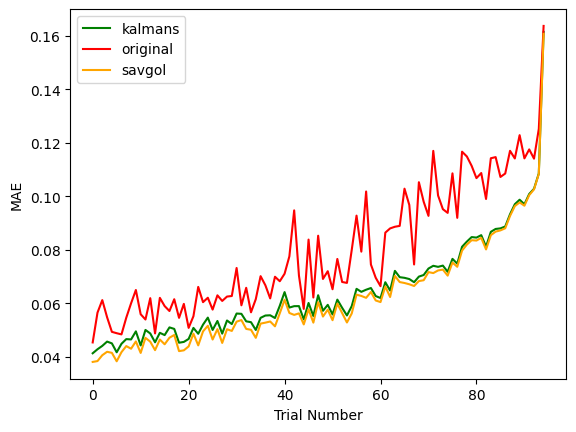

In [18]:
fig4, ax1 = plt.subplots()
filtfilts = []
originals = []
kalmans = []
tempfiles = []
soses = []
zerokalman = []
savgol = []

#get two lists of file names and filtfilt values where each index corresponds across lists
for each in MAEs:
    tempfiles.append(each)
    filtfilts.append(MAEs[each]["filtfilt"])
#sort each list by filtfilt MSE, preserves correspondance
sortedfilts, sortedfiles = (list(t) for t in zip(*sorted(zip(filtfilts, tempfiles))))
#generate lists of kalman and orignal that correspond
for each in sortedfiles:
    kalmans.append(MAEs[each]["kalman"])
    originals.append(MAEs[each]["original"])
    zerokalman.append(MAEs[each]["zerokalman"])
    savgol.append(MAEs[each]["savgol"])

    # soses.append(MAEs[each]["sos"])

ax1.plot(sortedfilts, label="filtfilt", color="gray")
ax1.plot(kalmans, label="kalmans", color="green")
ax1.plot(originals, label="original", color="red")
ax1.plot(zerokalman, label="zero phase kalmans", color="purple")
ax1.plot(savgol, label="savgol", color="orange") #performs almost identically to kalmanfiltfilt
ax1.plot(soses, label="new-sos", color="purple")
ax1.set_xlabel("Trial Number")
ax1.set_ylabel("MAE")

plt.legend(loc="upper left")

kalmanWins = 0
filtWins = 0 
for each in MAEs:
    if MAEs[each]["filtfilt"] < MAEs[each]["kalman"]:
        filtWins+=1
    elif MAEs[each]["filtfilt"] > MAEs[each]["kalman"]:
        kalmanWins+=1
print(kalmanWins, filtWins)